# Using `bw2waterbalancer`

Notebook showing typical usage of `bw2waterbalancer`

## Generating the samples

`bw2waterbalancer` works with Brightway2. You only need set as current a project in which the database for which you want to balance water exchanges is imported.

In [1]:
import brightway2 as bw
import numpy as np
bw.projects.set_current('ei36cutoff')

The only Class you need is the `DatabaseWaterBalancer`:

In [2]:
from bw2waterbalancer import DatabaseWaterBalancer

Instantiating the DatabaseWaterBalancer will automatically identify activities that are associated with water exchanges. 

In [3]:
dwb = DatabaseWaterBalancer(
    ecoinvent_version="3.6", # used to identify activities with water production exchanges
    database_name="ei36_cutoff", #name the LCI db in the brightway2 project
)

Validating data
Getting information on technosphere water exchanges


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Getting information on biosphere water exchanges


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:49


Generating presamples for the whole database is a lengthy process. Thankfully, it only ever needs to be done once per database:

In [4]:
dwb.add_samples_for_all_acts(iterations=1000)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 02:59:48


The samples and associated indices are stored as attributes: 

In [5]:
dwb.matrix_samples

array([[ 1.04352951e-04,  1.35944232e-04,  2.06009079e-04, ...,
         2.47270819e-04,  1.12496043e-04,  2.51163214e-04],
       [ 8.50888578e-04,  1.00799771e-03,  8.83137768e-04, ...,
         7.34778670e-04,  5.39244202e-04,  6.95238846e-04],
       [ 9.55241529e-04,  1.14394194e-03,  1.08914685e-03, ...,
         9.82049488e-04,  6.51740245e-04,  9.46402060e-04],
       ...,
       [ 6.86263392e-07,  6.33050532e-07,  8.14294829e-07, ...,
         9.64987748e-07,  6.27834675e-07,  1.21880872e-06],
       [-3.93123930e-03, -4.00336445e-03, -3.26208195e-03, ...,
        -3.22872164e-03, -4.06910916e-03, -2.88886878e-03],
       [ 5.20718858e-06,  5.23691965e-06,  4.56568907e-06, ...,
         4.67801763e-06,  5.30731021e-06,  4.54100782e-06]])

In [6]:
dwb.matrix_samples.shape

(26640, 1000)

In [7]:
dwb.matrix_indices[0:10] # First ten indices

[(('biosphere3', '075e433b-4be4-448e-9510-9a5029c1ce94'),
  ('ei36_cutoff', 'd0fac494176f7206524a5561ee1e85c5'),
  'biosphere'),
 (('biosphere3', '2404b41a-2eed-4e9d-8ab6-783946fdf5d6'),
  ('ei36_cutoff', 'd0fac494176f7206524a5561ee1e85c5'),
  'biosphere'),
 (('biosphere3', '831f249e-53f2-49cf-a93c-7cee105f048e'),
  ('ei36_cutoff', 'd0fac494176f7206524a5561ee1e85c5'),
  'biosphere'),
 (('biosphere3', '2404b41a-2eed-4e9d-8ab6-783946fdf5d6'),
  ('ei36_cutoff', '0a48c800e5747cc42ba09f33fb04afb0'),
  'biosphere'),
 (('biosphere3', 'fc1c42ce-a759-49fa-b987-f1ec5e503db1'),
  ('ei36_cutoff', '0a48c800e5747cc42ba09f33fb04afb0'),
  'biosphere'),
 (('biosphere3', '075e433b-4be4-448e-9510-9a5029c1ce94'),
  ('ei36_cutoff', '0a48c800e5747cc42ba09f33fb04afb0'),
  'biosphere'),
 (('biosphere3', '2404b41a-2eed-4e9d-8ab6-783946fdf5d6'),
  ('ei36_cutoff', '45730b731e0959f6e880cc40ea48197e'),
  'biosphere'),
 (('biosphere3', '075e433b-4be4-448e-9510-9a5029c1ce94'),
  ('ei36_cutoff', '45730b731e0959f6e880

In [8]:
len(dwb.matrix_indices)

26640

These can directly be used to generate [`presamples`](https://presamples.readthedocs.io/):

In [9]:
presamples_id, presamples_fp = dwb.create_presamples(
    name=None, #Could have specified a string as name, not passing anything will use automatically generated random name
    dirpath=None, #Could have specified a directory path to save presamples somewhere specific 
    id_=None, #Could have specified a string as id, not passing anything will use automatically generated random id
    seed='sequential', #or None, or int.
    )

Presamples with id_ d531ce33faed4bea882f1ce1a61b8608 written at C:\Users\Pascal Lesage\AppData\Local\pylca\Brightway3\ei36cutoff.e8d08b39952c787ab81510769bc7a655\presamples\d531ce33faed4bea882f1ce1a61b8608


## Using the samples

The samples are formatted for use in brighway2 via the presamples package. 

The following function calculates:  
  - Deterministic results, using `bw.LCA`  
  - Stochastic results, using `bw.MonteCarloLCA`  
  - Stochastic results using presamples, using `bw.MonteCarloLCA` and passing `presamples=[presamples_fp]`  
  
The ratio of stochastic results to deterministic results are then plotted for Monte Carlo results with and without presamples.  
Ratios for Monte Carlo with presamples are on the order of 1.  
Ratios for Monte Carlo without presamples are much greater, as much (for the randomly selected activities) up to two orders of magnitude.    

In [10]:
def check_presamples_act(act_key, ps_fp, lcia_method, iterations=1000):
    """Plot histrograms of Monte Carlo samples/det result for case w/ and w/o presamples"""
    lca = bw.LCA({act_key:1}, method=m)
    lca.lci()
    lca.lcia()
    
    mc_arr_wo = np.empty(shape=iterations)
    mc = bw.MonteCarloLCA({act_key:1}, method=m)
    for i in range(iterations):
        mc_arr_wo[i] = next(mc)/lca.score
    
    mc_arr_w = np.empty(shape=iterations)
    mc_w = bw.MonteCarloLCA({act_key:1}, method=m, presamples=[ps_fp])
    for i in range(iterations):
        mc_arr_w[i] = next(mc_w)/lca.score
    
    plt.hist(mc_arr_wo, histtype="step", color='orange', label="without presamples")
    plt.hist(mc_arr_w, histtype="step", color='green', label="with presamples")
    plt.legend()

Let's run this on a couple of random ecoinvent products with the ImpactWorld+ water scarcity LCIA method:

In [11]:
m=('IMPACTWorld+ (Default_Recommended_Midpoint 1.23)', 'Midpoint', 'Water scarcity')

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Randomly working on  'treatment of waste gypsum, sanitary landfill' (kilogram, CH, None)


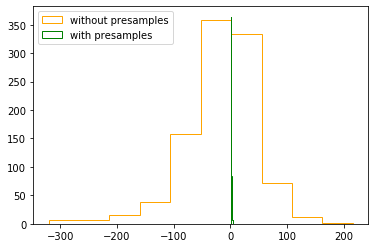

In [14]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'market for decommissioned pipeline, natural gas' (kilogram, CH, None)


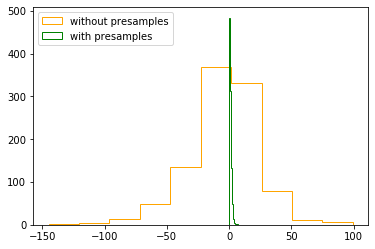

In [15]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'mine construction, open cast, steatite' (unit, RoW, None)


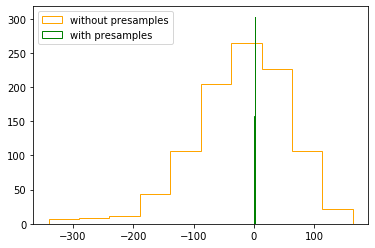

In [16]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'printed wiring board mounting facility construction, surface mounting line' (unit, GLO, None)


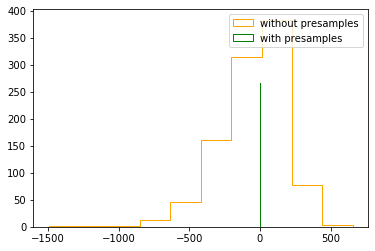

In [17]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'electricity production, nuclear, pressure water reactor' (kilowatt hour, BG, None)


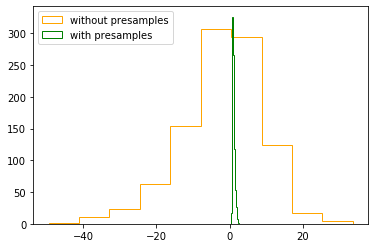

In [18]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)